# 情報活用講座：　ケモインフォマテックス 編　
# 第6回：　BRICSを使った構造生成と仮想分子ライブラリ

## 底本
船津 公人、柴山 翔二郎 **『実践 マテリアルズインフォマティクス　Pythonによる材料設計のための機械学習』**、近代科学社、2020  
第８章　構造生成による構造提案


## データセット
delaney-processed.csvは1128化合物の水溶解度についてのデータセットです。このデータセットは、Delaneyの論文『ESOL: Estimating Aqueous Solubility Directly from Molecular Structure』[1] で発表されたものに基づいています。

[1] John S. Delaney, "ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure", J. Chem. Inf. Comput. Sci. 44, 1000–1005 (2004) (DOI: 10.1021/ci034243x)  

Delaney-processed.csvは、分子の化学式、SMILES表記、また、水溶解度としてオクタノール水分配係数が含まれており、これらの特性は薬物探索や環境影響評価などの目的で使用されています。


1. Compound ID	：化合物ID
1. ESOL predicted log solubility in mols per litre　：log水溶解度（オクタノール水分配係数）の予測値	
1. Minimum Degree：　最小次数	
1. Molecular Weight：分子量	
1. Number of H-Bond Donors	：　水素結合に関与するDonor数
1. Number of Rings	：芳香環の数	
1. Number of Rotatable Bonds　：　回転可能結合数	
1. Polar Surface Area　：　極性表面積	
1. measured log solubility in mols per litre：log水溶解度の実測値	
1. smiles：SMILES表記


## pythonライブラリ


**NumPy**：　高性能の数値計算やデータ処理に特化したPythonのライブラリです。NumPyは多次元の配列や行列を効率的に操作する機能を提供し、科学技術計算やデータ解析の分野で広く使用されています。

**Pandas**：　データ操作と解析のための高レベルのPythonライブラリです。Pandasは、テーブル形式のデータを効率的に処理し、データのフィルタリング、変換、集約、および結合などの機能を提供します。データの整形やクリーニング、欠損値の処理などを容易に行うことができます。

**Matplotlib**：　Pythonでデータを可視化するための強力なライブラリです。Matplotlibは、グラフや図を描画するための多様な機能を提供し、折れ線グラフ、ヒストグラム、散布図、バーチャートなどの多くのプロットスタイルをサポートしています。データの傾向や関係性を視覚的に理解するための強力なツールです。

**RDkit**：　RDKitは、化学情報学や薬学の分野で広く使用されるオープンソースのソフトウェア開発キットです。RDKitはPythonで実装されており、様々な化学情報の処理や分子の構造解析、化学反応の予測などをサポートします。

## 目標

分子のフラグメント化アルゴリズムである**BRICS（Breaking of Retrosynthetically Interesting Chemical Substructures)** [1]を使い、仮想的な分子ライブラリを作成します。BRICSを使った分子の構造生成についてPythonで学ぶポイントを以下にまとめました。


* BRICSの適用: RDKitの`rdkit.Chem.BRICS.BRICSDecompose()`メソッドを使用して、BRICSを適用し分子を分解します。このメソッドは、分解された部分構造のジェネレータを返します。

* 生成された部分構造の操作: 分解された部分構造は、Pythonのリストとして取得できます。これらの部分構造を組み合わせて新しい分子を作成するために、必要な操作を実行できます。例えば、部分構造を結合したり、部分構造を変更したりすることができます。

* 新しい分子の生成: 部分構造の組み合わせに基づいて、新しい分子を生成します。


[1] Jörg Degen, Christof Wegscheid-Gerlach, Andrea Zaliani, Matthias Rarey, 「On the Art of Compiling and Using ‘Drug‐Like’ Chemical Fragment Spaces」, ChemMedChem, 3, 1503. 2008. (DOI:10.1002/cmdc.200800178)

# Google Colabにおける環境設定
google colab環境でなければ実行不要

In [ ]:
!pip install rdkit-pypi
!git clone https://github.com/ARIM-Training/Training_python_6.git
%cd Training_python_6

## 1.分子構造データの読み込み
### 汎用ライブラリのインポート

In [46]:
import pandas as pd 
import numpy as np

# RDKit関連
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import MolFromSmiles

from time import time
from multiprocessing import Pool

from warnings import filterwarnings
filterwarnings('ignore')# 警告を無視

### サンプルファイルの読み込み

In [2]:
df = pd.read_csv('./data/delaney-solubility/delaney-processed.csv')
df

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.770,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.300,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.060,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.870,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.330,c1ccsc1
...,...,...,...,...,...,...,...,...,...,...
1123,halothane,-2.608,1,197.381,0,0,0,0.00,-1.710,FC(F)(F)C(Cl)Br
1124,Oxamyl,-0.908,1,219.266,1,0,1,71.00,0.106,CNC(=O)ON=C(SC)C(=O)N(C)C
1125,Thiometon,-3.323,1,246.359,0,0,7,18.46,-3.091,CCSCCSP(=S)(OC)OC
1126,2-Methylbutane,-2.245,1,72.151,0,0,1,0.00,-3.180,CCC(C)C


In [3]:
df['mol'] = df['smiles'].apply(MolFromSmiles)
df

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,mol
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.770,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,<rdkit.Chem.rdchem.Mol object at 0x0000026A6A2...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.300,Cc1occc1C(=O)Nc2ccccc2,<rdkit.Chem.rdchem.Mol object at 0x0000026A6A2...
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.060,CC(C)=CCCC(C)=CC(=O),<rdkit.Chem.rdchem.Mol object at 0x0000026A6A2...
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.870,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,<rdkit.Chem.rdchem.Mol object at 0x0000026A6A2...
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.330,c1ccsc1,<rdkit.Chem.rdchem.Mol object at 0x0000026A6A2...
...,...,...,...,...,...,...,...,...,...,...,...
1123,halothane,-2.608,1,197.381,0,0,0,0.00,-1.710,FC(F)(F)C(Cl)Br,<rdkit.Chem.rdchem.Mol object at 0x0000026A6A2...
1124,Oxamyl,-0.908,1,219.266,1,0,1,71.00,0.106,CNC(=O)ON=C(SC)C(=O)N(C)C,<rdkit.Chem.rdchem.Mol object at 0x0000026A6A2...
1125,Thiometon,-3.323,1,246.359,0,0,7,18.46,-3.091,CCSCCSP(=S)(OC)OC,<rdkit.Chem.rdchem.Mol object at 0x0000026A6A2...
1126,2-Methylbutane,-2.245,1,72.151,0,0,1,0.00,-3.180,CCC(C)C,<rdkit.Chem.rdchem.Mol object at 0x0000026A6A2...


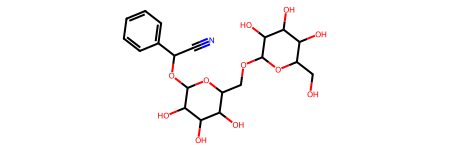

In [4]:
df['mol'][0]

## 2.BRICSによる分子ライブラリの作成

### フラグメント化（部分構造化）

RDKitの`BRICS.BRICSDecompose`関数は、分子をBRICS (Bristol-Myers Squibb Reaction-Inspired Clustering System) 法に基づいてフラグメント化するための機能を提供します。

BRICSスクリプトの読み込み: BRICSスクリプトを使用するために、PythonスクリプトでBRICSスクリプトを読み込む必要があります。以下のコードを使用して、BRICSスクリプトを読み込みます。

In [5]:
from rdkit.Chem import BRICS

フラグメント化によって、元の分子が複数のフラグメントに分割され、それぞれのフラグメントが独立した化学構造となります。なお、デフォルトでは切断位置にダミーアトムを挿入して表示されます。

In [6]:
frag0 = BRICS.BRICSDecompose(df['mol'][0])
frag0

{'[13*]C1OC([13*])C(O)C(O)C1O',
 '[16*]c1ccccc1',
 '[3*]O[3*]',
 '[4*]C([8*])C#N',
 '[4*]C[8*]',
 '[8*]CO'}

In [7]:
 len(frag0)

6

`returnMols`オプションでTrueを指定してフラグメント化した骨格をMolかさせておくと、`MolsToGridImage()`関数で視覚化することが楽になります。上記の6つの部分骨格は、次のような構成になっています。

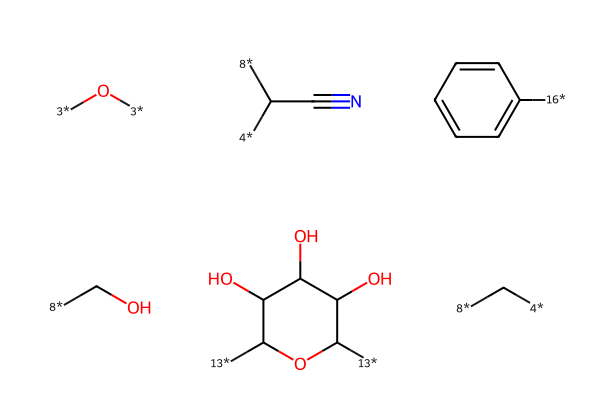

In [8]:
frag0_mols = BRICS.BRICSDecompose(df['mol'][0], returnMols=True)
Draw.MolsToGridImage(frag0_mols, molsPerRow=3)

### フラグメントライブラリ作成
上記は1分子でのフラグメントの方法でした。次はdelaney-processed.csvにある1128分子のフラグメント化を行い、重複のない固有のフラグメントをリストとしてライブラリ化してみましょう。

まず、三項演算子を使い、dfの['mol']を逐次、BRICS.BRICSDecompose()関数へmolという変数で受け渡し、list()関数でリスト配置をとらせます。

In [9]:
fragments = [list(BRICS.BRICSDecompose(mol)) for mol in df['mol']]
fragments

[['[8*]CO',
  '[4*]C[8*]',
  '[13*]C1OC([13*])C(O)C(O)C1O',
  '[16*]c1ccccc1',
  '[3*]O[3*]',
  '[4*]C([8*])C#N'],
 ['[16*]c1ccoc1C', '[16*]c1ccccc1', '[1*]C([6*])=O', '[5*]N[5*]'],
 ['[7*]CCCC([7*])C', '[7*]CC=O', '[7*]C(C)C'],
 ['c1ccc2c(c1)ccc1c2ccc2c3ccccc3ccc21'],
 ['c1ccsc1'],
 ['c1ccc2scnc2c1'],
 ['[16*]c1c(Cl)cc(Cl)cc1Cl', '[16*]c1c(Cl)cccc1Cl'],
 ['CC12CCC3c4ccc(O)cc4CCC3C1CCC2O'],
 ['ClC1=C(Cl)C2(Cl)C3C4CC(C5OC45)C3C1(Cl)C2(Cl)Cl'],
 ['[3*]OC', '[16*]c1cc2c(cc1[16*])C1C(=O)c3ccc4c(c3OC1CO2)CC(C(=C)C)O4'],
 ['O=C1CCCN1'],
 ['Clc1ccc2ccccc2c1'],
 ['C=CCCC'],
 ['[16*]c1ccccc1', '[8*]CC', '[15*]C1([15*])C(=O)NCNC1=O'],
 ['CCCCCCCCCCCCCC'],
 ['CC(C)Cl'],
 ['CCC(C)CO'],
 ['N#Cc1ccccc1'],
 ['[3*]OP(=S)(O[3*])O[3*]', '[4*]CC', '[8*]C(C)C', '[14*]c1cc(C)nc([14*])n1'],
 ['CCCCCCCCCC(C)O'],
 ['[16*]c1ccc(Cl)cc1Cl', '[16*]c1c(Cl)ccc(Cl)c1Cl'],
 ['[15*]C1CCCCC1', '[9*]n1c(=O)[nH]c2c(c1=O)CCC2'],
 ['[4*]CC', '[3*]OP(=S)(O[3*])SCS[11*]'],
 ['[4*]CC', '[16*]c1ccc([16*])cc1', '[5*]N[5*]', '[3

In [10]:
len(fragments)

1128

このように1128分子のネスト化されたリスト構造となっています。ネストを解消させてフラグメントのリスト構造とする方法として、次のようなunwrap関数を準備します。

In [11]:
def unwrap(list_data):
    list_output = []
    for li in list_data: 
        list_output += li
    return list_output

unwrap関数にかけると、フラグメントの総数は2315のパーツであることがわかります。

In [12]:
fr_all = unwrap(fragments)
fr_all

['[8*]CO',
 '[4*]C[8*]',
 '[13*]C1OC([13*])C(O)C(O)C1O',
 '[16*]c1ccccc1',
 '[3*]O[3*]',
 '[4*]C([8*])C#N',
 '[16*]c1ccoc1C',
 '[16*]c1ccccc1',
 '[1*]C([6*])=O',
 '[5*]N[5*]',
 '[7*]CCCC([7*])C',
 '[7*]CC=O',
 '[7*]C(C)C',
 'c1ccc2c(c1)ccc1c2ccc2c3ccccc3ccc21',
 'c1ccsc1',
 'c1ccc2scnc2c1',
 '[16*]c1c(Cl)cc(Cl)cc1Cl',
 '[16*]c1c(Cl)cccc1Cl',
 'CC12CCC3c4ccc(O)cc4CCC3C1CCC2O',
 'ClC1=C(Cl)C2(Cl)C3C4CC(C5OC45)C3C1(Cl)C2(Cl)Cl',
 '[3*]OC',
 '[16*]c1cc2c(cc1[16*])C1C(=O)c3ccc4c(c3OC1CO2)CC(C(=C)C)O4',
 'O=C1CCCN1',
 'Clc1ccc2ccccc2c1',
 'C=CCCC',
 '[16*]c1ccccc1',
 '[8*]CC',
 '[15*]C1([15*])C(=O)NCNC1=O',
 'CCCCCCCCCCCCCC',
 'CC(C)Cl',
 'CCC(C)CO',
 'N#Cc1ccccc1',
 '[3*]OP(=S)(O[3*])O[3*]',
 '[4*]CC',
 '[8*]C(C)C',
 '[14*]c1cc(C)nc([14*])n1',
 'CCCCCCCCCC(C)O',
 '[16*]c1ccc(Cl)cc1Cl',
 '[16*]c1c(Cl)ccc(Cl)c1Cl',
 '[15*]C1CCCCC1',
 '[9*]n1c(=O)[nH]c2c(c1=O)CCC2',
 '[4*]CC',
 '[3*]OP(=S)(O[3*])SCS[11*]',
 '[4*]CC',
 '[16*]c1ccc([16*])cc1',
 '[5*]N[5*]',
 '[3*]O[3*]',
 '[1*]C(C)=O',
 '[8*]C(F

In [13]:
len(fr_all)

2315

フラグメントでは重複するものがありますので、ここではset()関数を使って、一意のフラグメントの集合をつくります。下記のように実行するとフラグメント数として1028となりました。すなわち約半分が重複していたことになります。

In [14]:
frag_library = set(fr_all)
frag_library 

{'[3*]OP(=S)(O[3*])ON=C(C#N)c1ccccc1',
 'CC(C)CCC(C)(C)C',
 '[14*]c1nc([14*])nc([14*])n1',
 '[14*]c1cccc(Cl)n1',
 'Cc1ccc(C)cc1',
 'O=c1[nH]cc(F)c(=O)[nH]1',
 '[1*]C(=O)CCCCCC',
 '[7*]C(C)OP(=S)(NCC)OC',
 '[4*]CCC',
 'C=CC(=C)C',
 '[5*]N1c2ncccc2C(=O)N(CC)c2cccnc21',
 'Nc1cc[nH]c(=O)n1',
 'CCCCCC(C)(C)O',
 'CC12CCC3c4ccc(O)cc4CCC3C1CC(O)C2O',
 '[8*]CC(O)CO',
 '[3*]OP(=S)(CC)O[3*]',
 'Cc1cc(C)c(O)c(C)c1',
 'C=CCCCCCC',
 'CC(C)CCO',
 'CCC=O',
 'CN1C(=O)CN=C(c2ccccc2)c2cc(Cl)ccc21',
 'Cc1cccc2ccccc12',
 'CCC#CCC',
 'c1ccc2c(c1)ccc1c2ccc2c3ccccc3ccc21',
 'CCCCCCC(C)=O',
 'Cc1cc2c3ccccc3ccc2c2ccccc12',
 'O=C1NC(=O)C2(CC2)C(=O)N1',
 'O=C1NC(=O)C(=O)C(=O)N1',
 'CCCCC',
 'c1ccc2c(c1)-c1cccc3cccc-2c13',
 'Clc1cccc(I)c1',
 '[16*]c1ccc(Cl)c(Cl)c1',
 '[8*]CCl',
 'Oc1ccc2c(c1)CCCC2',
 '[4*]C([8*])C#N',
 '[3*]OC=C',
 'CCC[N+](=O)[O-]',
 '[5*]N1c2ncccc2C(=O)Nc2c(C)cc(C)nc21',
 'CCCO',
 'CCCCCCCCCCCCO',
 'O=[N+]([O-])c1cccc2ccccc12',
 'O=[N+]([O-])C(Cl)(Cl)Cl',
 'CC1(C)C2CCC1(C)C(O)C2',
 'C=C',
 '[16*

In [15]:
print('BRICSが取り出した全フラグメント', len(set(fr_all)))

BRICSが取り出した全フラグメント 1028


### 部分構造の指定

In [33]:
import random 
random.seed(42)

list_fragments = [MolFromSmiles(smi)for smi in frag_library]

random.shuffle(list_fragments,random=random.random)

seed_structures = list_fragments[:2]
print(len(seed_structures))

2


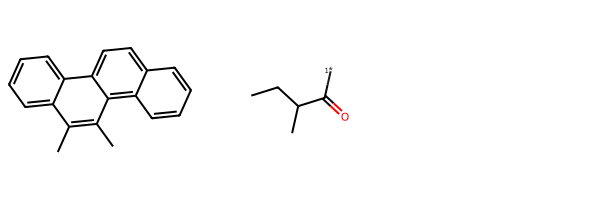

In [34]:
Draw.MolsToGridImage(seed_structures)

### 構造生成によるバーチャルライブラリーの構築

In [35]:
component = [MolFromSmiles(smi)for smi in frag_library]
build = BRICS.BRICSBuild(component) 

In [36]:
build

<generator object BRICSBuild at 0x0000026A71695120>

In [37]:
### 分子1000個を作成
generated_mols = []
for i in range(1000):
    m = next(build)
    m.UpdatePropertyCache(strict=True)
    generated_mols.append(m)

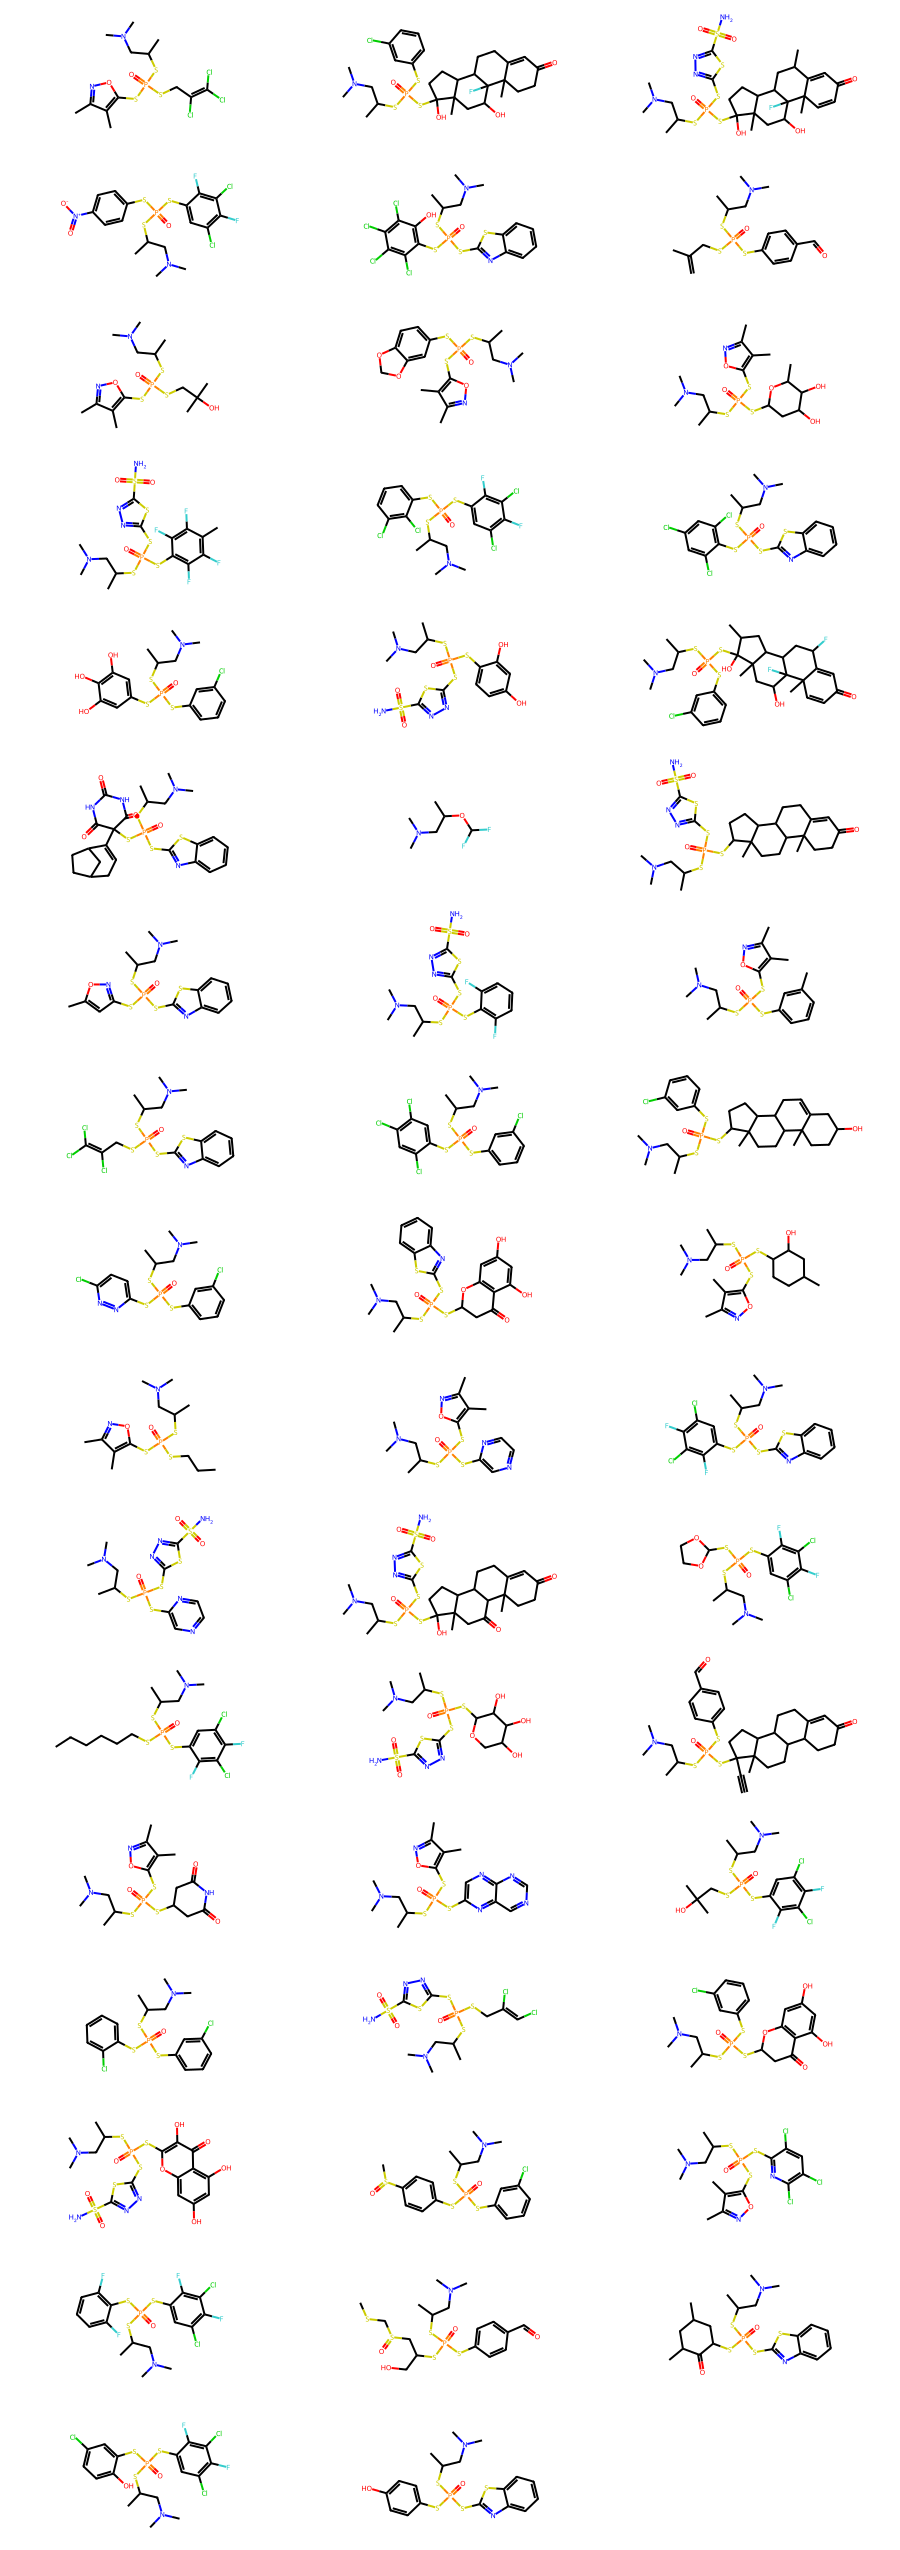

In [38]:
np.random.seed(1234)
np.random.shuffle(generated_mols)

Draw.MolsToGridImage(generated_mols[:90], molsPerRow=3, subImgSize=(300,150))

### 必須とする部分構造を含める場合など


|引数||
|:---|:---|
|fragments(第一引数)|ダミー原子を1箇所以上含むフラグメント。Molオブジェクトを持つ配列(list)として入力する。|
|seeds|フラグメントのうち、必ず含んでいて欲しい構造。|
|maxDepth|何回結合させるか|

In [39]:
build2 = BRICS.BRICSBuild(component, seeds = seed_structures, maxDepth = 3)

In [40]:
### 分子1000個を作成
generated_mols = []
for i in range(1000):
    m = next(build2)
    m.UpdatePropertyCache(strict=True)
    generated_mols.append(m)

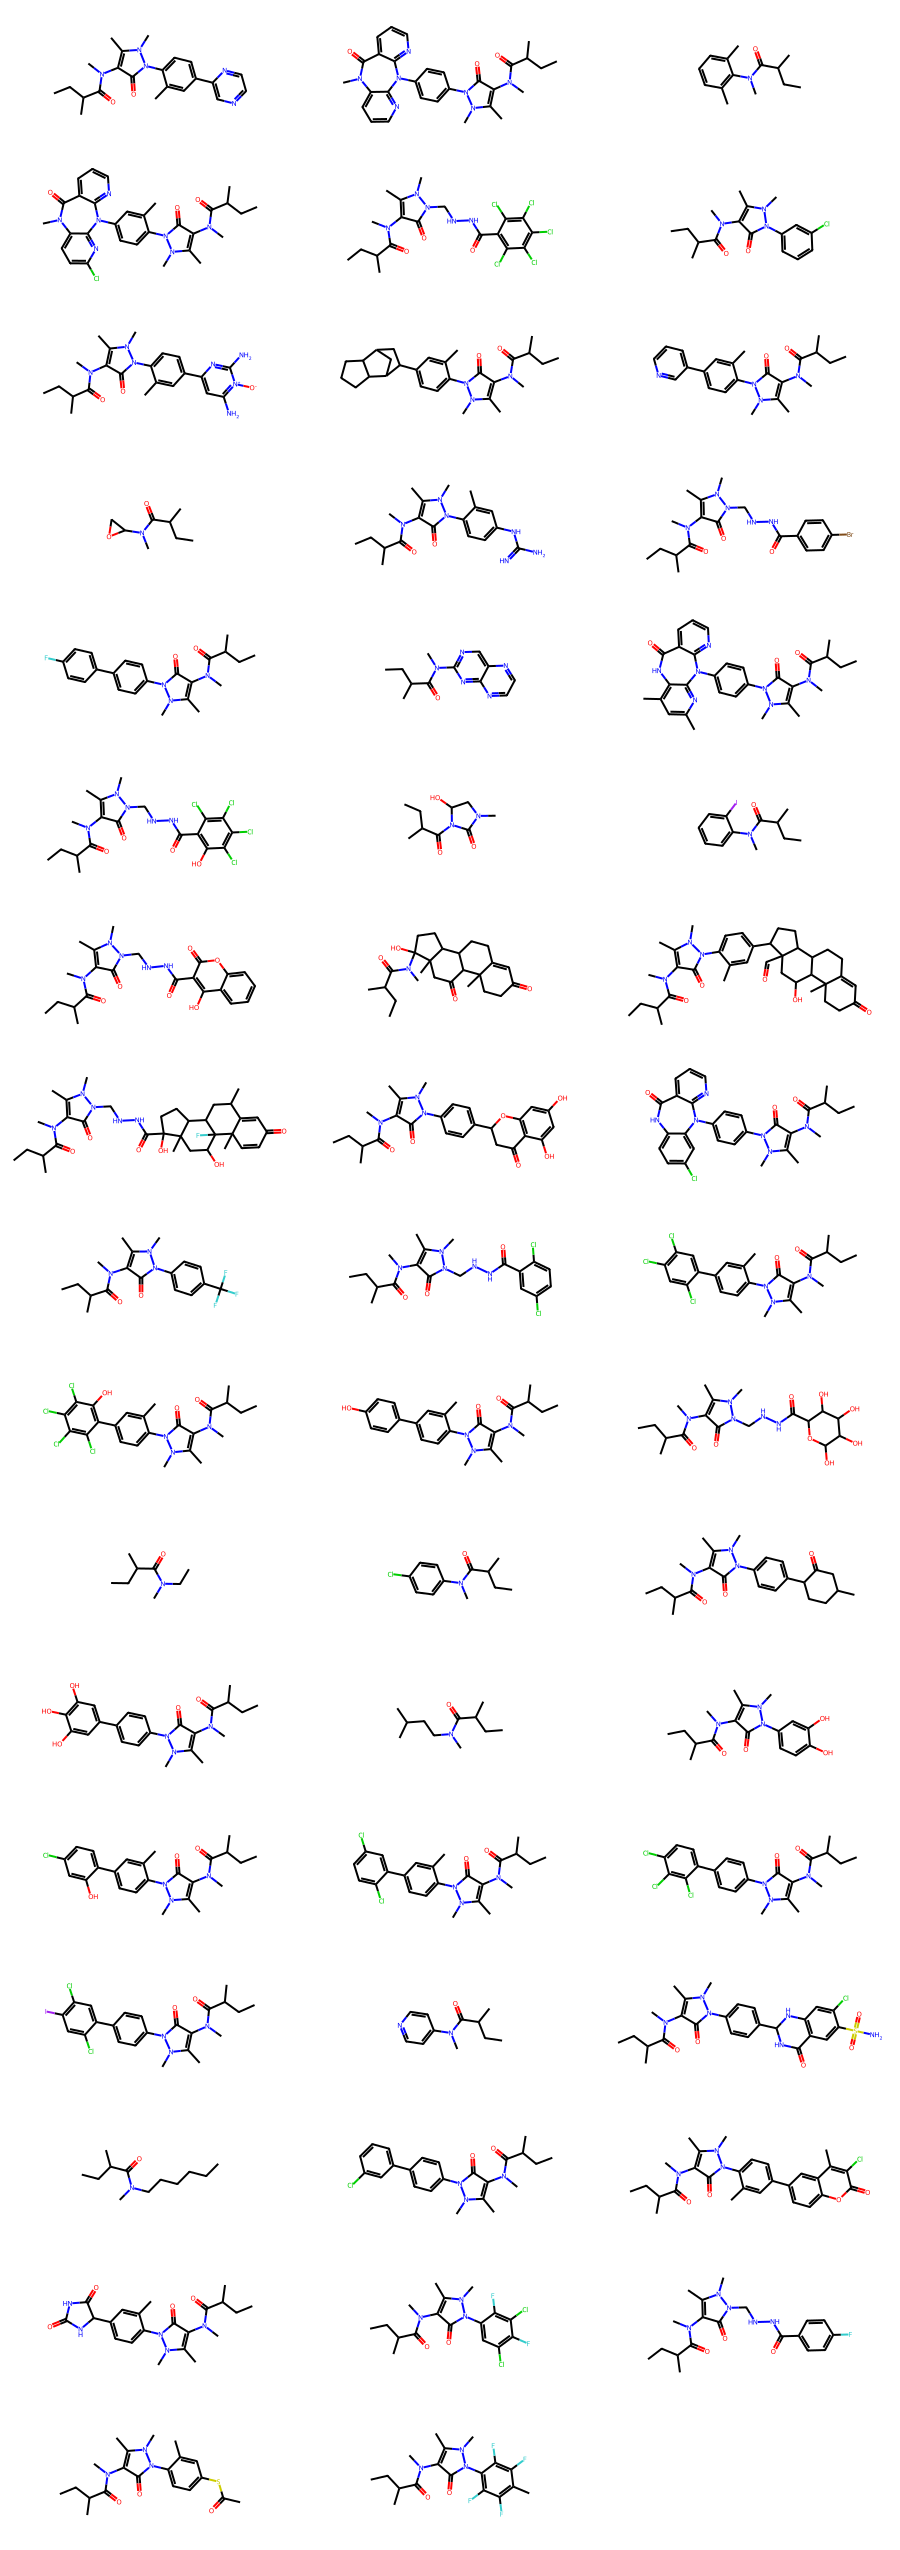

In [41]:
import numpy as np
np.random.seed(1234)
np.random.shuffle(generated_mols)
Draw.MolsToGridImage(generated_mols[:90], molsPerRow=3, subImgSize=(300,150))

## 3.一括処理

In [42]:
def stopwatch(t):
    """経過時間を測る関数"""
    return (time() - t)/60

def sample_molecule(mol):
    """
    multiprocessing.Pool.imapに渡す関数。
    Molオブジェクトの更新をしたあとでSMILESに変換。
    """
    mol.UpdatePropertyCache(strict=True)
    return Chem.MolToSmiles(mol)

In [43]:
df=pd.read_csv('./data/delaney-solubility/delaney-processed.csv',
              index_col=0)

TARGET=['measured log solubility in mols per litre']
df['mol'] = df['smiles'].apply(Chem.MolFromSmiles)

In [44]:
fragments = set()

for ix, mol in df[['mol']].iterrows():
    f = BRICS.BRICSDecompose(mol[0], returnMols=True)
    fragments.update(list(f))
    
else:
    print(len(fragments))

2315


In [47]:
NUM_ITER=1000
from random import seed
#--- starts parallel BRICS
start = time()
seed(20200315)
builder = BRICS.BRICSBuild(fragments)

with open('./results/mol_single.smi', 'w') as f:
    for i in range(NUM_ITER):
        m = next(builder)
        m.UpdatePropertyCache(strict=True)
        smi = Chem.MolToSmiles(m)
        f.write(smi+'\n')
print('Elapsed time', stopwatch(start), '[mins]')

Elapsed time 0.08691962957382202 [mins]


In [ ]:
#--- starts parallel BRICS

NUM_ITER=100

start2 = time()
c = 0
seed(20200315)
builder = BRICS.BRICSBuild(fragments)

with Pool(4) as p:
    f = open('./results/mol_quad.smi', 'w')
    for smi in p.imap(func=sample_molecule, iterable=builder, chunksize=100):
        f.write(smi+'\n')
        c+=1
        if c == NUM_ITER:
            print(c)
            break
    f.close()
print('Elapsed time', stopwatch(start2), '[mins]')